In [21]:
from doepy import build
from concurrent.futures import ThreadPoolExecutor  # or ProcessPoolExecutor if you want to use multiple processes
from sklearn.linear_model import LinearRegression 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests 
import json
import random
import yaml

In [47]:
# Helpers
def applyThreaded(df, func, max_workers=4, col_name='time'):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(func, df.itertuples(index=False)))

    df[col_name] = results
    return df

global_config_space = {
    'CPU':[.5,4,16],
    'Mem':[248, 1024, 1024*16],
    'NodeType':["GPU1", "GPU2", "GPU3"]
}

In [48]:
def genConfigs(config_space=None):
    if not config_space:
        config_space = global_config_space
    doe = build.full_fact(config_space)
    doe['i'] = doe.index + 1
    doe['NodeTypeStr'] = list(map(lambda nt: config_space['NodeType'][int(nt)], doe['NodeType']))
    return doe

doe = genConfigs(global_config_space)
doe

/Users/cameron.keenan/.pyenv/versions/FaaSterConfig/lib/python3.11/site-packages/doepy/doe_functions.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'GPU1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.iloc[i][j]=r[j][int(df.iloc[i][j])]
/Users/cameron.keenan/.pyenv/versions/FaaSterConfig/lib/python3.11/site-packages/doepy/doe_functions.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'GPU2' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.iloc[i][j]=r[j][int(df.iloc[i][j])]
/Users/cameron.keenan/.pyenv/versions/FaaSterConfig/lib/python3.11/site-packages/doepy/doe_functions.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'GPU3' has dtype incompatible with float32, please 

,CPU,Mem,NodeType,i,NodeTypeStr
0,0.5,248.0,0.0,1,GPU1
1,4.0,248.0,0.0,2,GPU1
2,16.0,248.0,0.0,3,GPU1
3,0.5,1024.0,0.0,4,GPU1
4,4.0,1024.0,0.0,5,GPU1
5,16.0,1024.0,0.0,6,GPU1
6,0.5,16384.0,0.0,7,GPU1
7,4.0,16384.0,0.0,8,GPU1
8,16.0,16384.0,0.0,9,GPU1
9,0.5,248.0,1.0,10,GPU2


In [49]:
def getConfigResultsRandom(row):
    url = f"https://jsonplaceholder.typicode.com/posts/{int(row.i)}"
    response = requests.get(url)
    data = json.loads(response.text)
    random.seed(data['id'])
    return random.random()*30

def getConfigResultsFaked(row, sigma=.1):
    random.seed(row.i)
    b = random.normalvariate(.5, sigma)
    return b + random.normalvariate(1/(row.CPU * 3 + row.Mem*1.5 * row.NodeType), sigma)


In [50]:
applyThreaded(doe, getConfigResultsFaked, 4)

,CPU,Mem,NodeType,i,NodeTypeStr,time
0,0.5,248.0,0.0,1,GPU1,1.225990
1,4.0,248.0,0.0,2,GPU1,0.843409
2,32.0,248.0,0.0,3,GPU1,0.355460
3,0.5,1024.0,0.0,4,GPU1,1.095074
4,4.0,1024.0,0.0,5,GPU1,0.513782
5,32.0,1024.0,0.0,6,GPU1,0.485701
6,0.5,16384.0,0.0,7,GPU1,1.158991
7,4.0,16384.0,0.0,8,GPU1,0.271606
8,32.0,16384.0,0.0,9,GPU1,0.524577
9,0.5,248.0,1.0,10,GPU2,0.541000


In [51]:
df = doe.copy()

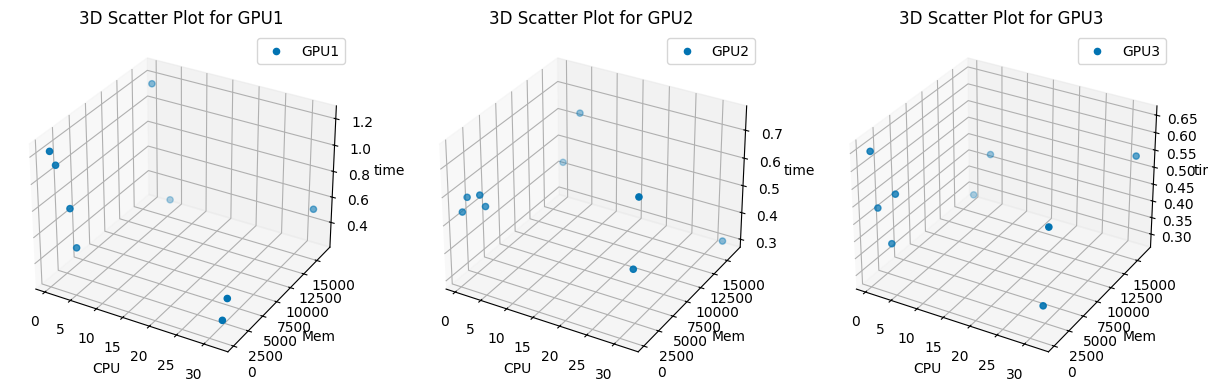

In [52]:
# Assuming 'x_var' and 'y_var' are your numerical variables, and 'z_var' is your response variable
x_var = 'CPU'
y_var = 'Mem'
z_var = 'time'
categorical_var = 'NodeTypeStr'

# Get unique categories in your categorical variable
categories = df[categorical_var].unique()

fig = plt.figure(figsize=(15, 10))

# Loop through categories and create 3D scatter plots
for i, category in enumerate(categories):
    subset = df[df[categorical_var] == category]
    
    ax = fig.add_subplot(1, len(categories), i + 1, projection='3d')    
    ax.scatter(subset[x_var], subset[y_var], subset[z_var], label=category)
    
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.set_zlabel(z_var)
    
    ax.set_title(f'3D Scatter Plot for {category}')
    ax.legend()

plt.show()


In [9]:
def readStack(path='../openFaas/stack.yml'):
    # Open and read a YAML file
    with open(path, 'r') as file:
        data = yaml.safe_load(file)
        
    return data
    
def writeStack(data, path='../openFaas/stack.yml'):
    with open(path, 'w') as file:
        yaml.dump(data, file, default_flow_style=False)

In [11]:
data = readStack()
writeStack(data)

In [ ]:
default

In [19]:
data["functions"]['greeter']

{'lang': 'python3',
 'handler': './greeter',
 'image': 'greeter:latest',
 'limits': {'memory': '40m', 'cpu': 4},
 'requests': {'memory': '20m', 'cpu': 4}}

In [55]:
def generateFunctions(funcName, config_space=None, stackPath='../openFaas/stack.yml'):
    stack = readStack(stackPath)
    if not (data.get('functions', False) and data['functions'].get(funcName, False)):
        return f"{funcName} not found in {stackPath}"
    
    functions = data['functions']
    funcConfig = functions[funcName]
    
    if not config_space:
        config_space = global_config_space
        
    doe = genConfigs(config_space)
    
    for inx, row in doe.iterrows():
        name = f"{funcName}_CPU{row.CPU}_Mem_{row.Mem}_{row.NodeTypeStr}"
        config = funcConfig.copy()
        config['limits'] = {
            'cpu': row.CPU,
            "memory": f"{row.Mem}m"
        }
        config['requests'] = config['limits'].copy()
        functions[name] = config
    
    stack['functions'] = functions
    return stack


In [56]:
stack = generateFunctions("greeter")
writeStack(stack)

/Users/cameron.keenan/.pyenv/versions/FaaSterConfig/lib/python3.11/site-packages/doepy/doe_functions.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'GPU1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.iloc[i][j]=r[j][int(df.iloc[i][j])]
/Users/cameron.keenan/.pyenv/versions/FaaSterConfig/lib/python3.11/site-packages/doepy/doe_functions.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'GPU2' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.iloc[i][j]=r[j][int(df.iloc[i][j])]
/Users/cameron.keenan/.pyenv/versions/FaaSterConfig/lib/python3.11/site-packages/doepy/doe_functions.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'GPU3' has dtype incompatible with float32, please 

In [36]:
i,row = next(doe.iterrows())

In [40]:
row.NodeTypeStr

'GPU1'

In [51]:
a = b = 1